#### [ Pytorch DL MODEL 실습 ]

- 데이터셋 : iris.csv 
- 학습방법 : 지도학습 + 분류 ==>  다중분류

[1] 모듈로딩 및 데이터 준비<hr>

In [1]:
## 모듈로딩
import pandas as pd                                     ## 데이터 관련 모듈들
import numpy as np 

import torch                                            ## Tensor 및 기본 함수들 관련 모듈들
import torch.nn as nn                                   ## 인공신경망 관련 모듈들
import torch.nn.functional as F                         ## 인공신경망 관련 함수들
import torch.optim as optim                             ## 최적화 모듈

from sklearn.model_selection import train_test_split    ## 학습용 데이터셋 관련 함수
from torch.utils.data import Dataset, DataLoader 				# 학습 데이터셋 관련모듈

In [2]:
## 데이터 준비
DATA_FILE = '../Data/iris.csv'

[2] 데이터 로딩 및 확인<hr>

In [3]:
## 데이터 로딩
irisDF = pd.read_csv(DATA_FILE)

irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
## 데이터 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
pd.set_option('future.no_silent_downcasting', True)
irisDF.variety=irisDF.variety.replace({'Setosa':0, 'Versicolor':1, 'Virginica':2})

In [6]:
irisDF.variety=irisDF.variety.astype('int')
irisDF.dtypes

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety           int64
dtype: object

[3] 데이터 셋 준비<hr>

In [7]:
## 피쳐와 타겟 분리 
featureDF =irisDF[irisDF.columns[:-1]]   # Feature 4개
targetSR = irisDF[irisDF.columns[-1]]    # 품종 1개

print(f'[FeatureDF] {featureDF.shape}, {featureDF.ndim}D')
print(f'[targetSR]  {targetSR.shape},  {targetSR.ndim}D')

[FeatureDF] (150, 4), 2D
[targetSR]  (150,),  1D


In [8]:
## 학습용, 테스트용 데이터셋 분리 
X_train, X_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR, 
                                                    test_size=0.2,
                                                    stratify=targetSR,
                                                    random_state=42)

print(f'[X_train] {X_train.shape}, {X_train.ndim}D  [y_train] {y_train.shape}, {y_train.ndim}D')
print(f'[X_test]  {X_test.shape}, {X_test.ndim}D  [y_test] {y_test.shape}, {y_test.ndim}D')


[X_train] (120, 4), 2D  [y_train] (120,), 1D
[X_test]  (30, 4), 2D  [y_test] (30,), 1D


In [9]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

[4] 모델 설계 및 클래스 구현<hr>

In [10]:
# 모델 클래스 설계 ----------------------------------------------------------------------
## 회귀용 커스텀 모델 
## 클래스이름 : IrisModel
## 부모클래스 : nn.Module
## 모델층구성   입력신호/피쳐수       출력신호수/퍼셉트론수       활성화함수
## - 입력층  :      4                     100                 ReLu
## - 은닉층  :     100                     30                 ReLu 
## - 출력층  :      30                     3                  Softmax => 손실함수 내 포함
## - -----------------------------------------------------------------------------------
class IrisModel(nn.Module):
    ## 모델 층 설계 및 초기화 메서드 
    def __init__(self):
        super().__init__()
        self.in_layer  = nn.Linear(4,  100)
        self.hd_layer  = nn.Linear(100, 30)
        self.out_layer = nn.Linear(30,  3)

    ## 학습 진행 메서드 
    def forward(self, data):
        ## 입력층
        out = F.relu( self.in_layer(data) )
        ## 은닉층
        out = F.relu( self.hd_layer(out) )
        ## 출력층
        return self.out_layer(out) 
    

In [11]:
# Series => DataFrame : to_frame()

type(y_train.to_frame())

pandas.core.frame.DataFrame

In [12]:
y_train[8].reshape(-1,1)

array([[0]])

In [13]:
# 여러개 원소 추출시 series 로 결과
type(y_train[[8,106]])

pandas.core.series.Series

# [4]  커스텀 데이터셋 클래스 설계 및 구현<hr>

In [14]:
# iris 전용 데이터셋 클래스

class IrisDataset(Dataset):
	# 피쳐와 타겟 분리 및 전처리
	def __init__(self, featureDF, targetDF):
		super().__init__()
		self.feature = featureDF
		self.target = targetDF
		self.rows = featureDF.shape[0]
		self.cols = featureDF.shape[1]
	
	# 데이터셋의 샘플 수 반환 메서드
	def __len__(self):
		return self.rows
	# DataLoader 에서 batch_size 만큼 호출하는 메서드
	# 인덱스에 해당하는  피쳐와 타겟 변환 단, Tensor 형태

	def __getitem__(self, index):
		print('__getitem__()', index)
		arrFeature = self.feature.iloc[index].values			# ndarray
		arrTarget = self.target[index].reshape(-1)              # ndarray로 변환 2D => 1D 변환 (필요에 따라)
		return torch.FloatTensor(arrFeature), torch.FloatTensor(arrTarget)



In [27]:
trainDS = IrisDataset(X_train,y_train)
trainDS[1]
print(type(trainDS))

__getitem__() 1
<class '__main__.IrisDataset'>


In [16]:
# DataLoader 로 확인
trainDL = DataLoader(dataset=trainDS, batch_size=3)
for feature, label in trainDL:
	print(feature, label, sep='\n' )
	break

__getitem__() 0
__getitem__() 1
__getitem__() 2
tensor([[4.4000, 2.9000, 1.4000, 0.2000],
        [4.9000, 2.5000, 4.5000, 1.7000],
        [6.8000, 2.8000, 4.8000, 1.4000]])
tensor([[0.],
        [0.],
        [0.]])


In [17]:
# 학습 => train 용 DataSet 필수
# 	   => Test 용 Dataset 선택 => 데이터가 많드면 DS,DL 생성사용
# 							  => 데이터가 많지 않다면 DS, DL 생성 필요 X
trainDS = IrisDataset(X_train,y_train)
testDS = IrisDataset(X_test,y_test)

print(trainDS[1])
print(testDS.feature, testDS.target)


__getitem__() 1
(tensor([4.9000, 2.5000, 4.5000, 1.7000]), tensor([0.]))
    sepal.length  sepal.width  petal.length  petal.width
0            4.4          3.0           1.3          0.2
1            6.1          3.0           4.9          1.8
2            4.9          2.4           3.3          1.0
3            5.0          2.3           3.3          1.0
4            4.4          3.2           1.3          0.2
5            6.3          3.3           4.7          1.6
6            4.6          3.6           1.0          0.2
7            5.4          3.4           1.7          0.2
8            6.5          3.0           5.2          2.0
9            5.4          3.0           4.5          1.5
10           7.3          2.9           6.3          1.8
11           6.9          3.1           5.1          2.3
12           6.5          3.0           5.8          2.2
13           6.4          3.2           4.5          1.5
14           5.0          3.4           1.5          0.2
15           5.

In [28]:
# DataLoader 로 확인
testDL = DataLoader(dataset=testDS, batch_size=3)
for feature, label in testDL:
	print(feature, label, sep='\n' )
	break

__getitem__() 0
__getitem__() 1
__getitem__() 2
tensor([[4.4000, 3.0000, 1.3000, 0.2000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [4.9000, 2.4000, 3.3000, 1.0000]])
tensor([[0.],
        [2.],
        [1.]])


In [19]:
## 모델 구조 확인
model = IrisModel()
print( model )

## shape 체크
data = torch.FloatTensor( [[1.,3.2, 1.9, 2.6]] )   # (1, 4)
model(data)

IrisModel(
  (in_layer): Linear(in_features=4, out_features=100, bias=True)
  (hd_layer): Linear(in_features=100, out_features=30, bias=True)
  (out_layer): Linear(in_features=30, out_features=3, bias=True)
)


tensor([[-0.1306,  0.4227,  0.3543]], grad_fn=<AddmmBackward0>)

[5] 학습 준비 <hr>

- [5-1]학습 관련 설정들

In [20]:

EPOCHS      = 100                                   # 학습용 DS을 처음부터 끝까지 1번 학습하는 것을 에포크
BATCH_SIZE  = 40                                    # DS을 학습량 만큼 나눈 사이즈 
ITERATION   = int(X_train.shape[0]/BATCH_SIZE)      # 학습용 DS이 분리된 수 => 1에포크에 W, b 업데이트 횟수

# 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정 
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE : {DEVICE}, EPOCHS : {EPOCHS}, BATCH_SIZE : {BATCH_SIZE} ITERATION : {ITERATION}')

DEVICE : cpu, EPOCHS : 100, BATCH_SIZE : 40 ITERATION : 3


- [5-2] 학습 관련 인스턴스들

In [21]:

LR        = 0.01  
MODEL     = IrisModel()                             ## 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   ## 최적화 즉, 경사하강법 알고리즘으로 W, b의 값 갱신
LOSS_FN   = nn.CrossEntropyLoss()                   ## 다중분류 손실함수


- [5-3] 학습관련 함수들

In [29]:

##- 검증 함수 --------------------------------------------
##- 검증용 데이터셋으로 모델 검증
##- 학습 지속여부 결정 기준이 됨
##- -----------------------------------------------------
def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    MODEL.eval()
    
    # W, b가 업데이트 해제
    with torch.no_grad():
        # 검증용 데이터셋 => 텐서화 ndarray ==> tensor변환
        x = testDS[0]
        y = testDS[1]
        # x = torch.FloatTensor(X_test.values) 
        # y = torch.FloatTensor(y_test.values)
        
        # 검증진행
        pre_y= MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())

    return loss.item()

In [23]:
##- 학습 함수 --------------------------------------------
##- 학습용 데이터셋으로 모델 검증
##- -----------------------------------------------------
def training():
    # 학습 모드 설정
    model.train()

    E_LOSS=0
    for i in range(ITERATION): 
        start = i*BATCH_SIZE
        end = start + BATCH_SIZE

        # ndarray ==> tensor변환
        x = torch.FloatTensor(X_train.values[start:end]) 
        y = torch.FloatTensor(y_train.values[start:end])
                                                                    
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(x)

        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1).long())
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        E_LOSS += loss.item()

    return E_LOSS/ITERATION

In [24]:
# 에포크 : DS 처음부터 ~ 끝까지 학습  
LOSS_HIST ={'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss = training()
    validLoss = evaluate()

    LOSS_HIST['Train'].append(trainLoss)
    LOSS_HIST['Valid'].append(validLoss)

    print(f'\nEPOCH[{epoch}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')


EPOCH[0/100]----------------
- TRAIN_LOSS 1.11804
- VALID_LOSS 0.97562

EPOCH[1/100]----------------
- TRAIN_LOSS 0.91620
- VALID_LOSS 0.80865

EPOCH[2/100]----------------
- TRAIN_LOSS 0.74659
- VALID_LOSS 0.62110

EPOCH[3/100]----------------
- TRAIN_LOSS 0.56257
- VALID_LOSS 0.47638

EPOCH[4/100]----------------
- TRAIN_LOSS 0.44891
- VALID_LOSS 0.40022

EPOCH[5/100]----------------
- TRAIN_LOSS 0.37646
- VALID_LOSS 0.33514

EPOCH[6/100]----------------
- TRAIN_LOSS 0.30353
- VALID_LOSS 0.26750

EPOCH[7/100]----------------
- TRAIN_LOSS 0.23847
- VALID_LOSS 0.20852

EPOCH[8/100]----------------
- TRAIN_LOSS 0.18159
- VALID_LOSS 0.16238

EPOCH[9/100]----------------
- TRAIN_LOSS 0.14627
- VALID_LOSS 0.13539

EPOCH[10/100]----------------
- TRAIN_LOSS 0.11727
- VALID_LOSS 0.10586

EPOCH[11/100]----------------
- TRAIN_LOSS 0.10131
- VALID_LOSS 0.09014

EPOCH[12/100]----------------
- TRAIN_LOSS 0.09344
- VALID_LOSS 0.08396

EPOCH[13/100]----------------
- TRAIN_LOSS 0.08348
- VALID_L

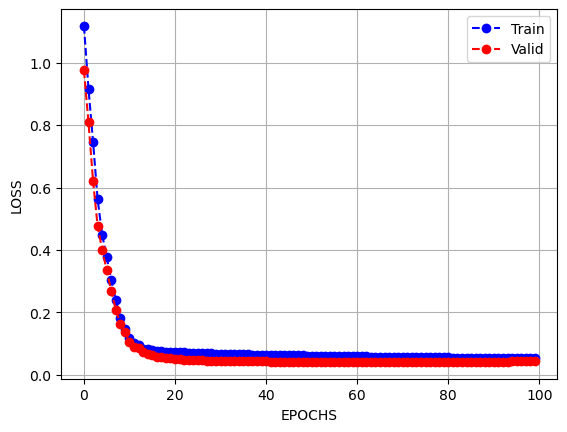

In [25]:
## 모델 성능 시각화 
import matplotlib.pyplot as plt

plt.plot(LOSS_HIST['Train'], 'bo--', label='Train')
plt.plot(LOSS_HIST['Valid'], 'ro--', label='Valid')
plt.grid()
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.show()